In [1]:
import pandas as pd
import numpy as np
import os
import nltk

pd.options.display.max_colwidth=100

In [2]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import RegexpTokenizer


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DarkoSarajkic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DarkoSarajkic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

## LOAD DATA AND AND ADD LABELS

In [4]:
MAIN_DIR_PATH="./bbc"
texts=[]
labels=[]
for dir_name in os.listdir(MAIN_DIR_PATH):
    path=MAIN_DIR_PATH+'/'+dir_name

    files=[path+'/'+file for file in os.listdir(path)]

    for file in files:
        with open(file) as txt_file:
            texts.append(txt_file.read())
            labels.append(dir_name)

In [5]:
data=pd.DataFrame(zip(texts,labels), columns=['text','label'])
data.head(10)

,text,label
0,Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% t...,business
1,Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in alm...,business
2,Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask ...,business
3,High fuel prices hit BA's profits\n\nBritish Airways has blamed high fuel prices for a 40% drop ...,business
4,Pernod takeover talk lifts Domecq\n\nShares in UK drinks and food firm Allied Domecq have risen ...,business
5,Japan narrowly escapes recession\n\nJapan's economy teetered on the brink of a technical recessi...,business
6,"Jobs growth still slow in the US\n\nThe US created fewer jobs than expected in January, but a fa...",business
7,"India calls for fair trade rules\n\nIndia, which attends the G7 meeting of seven leading industr...",business
8,"Ethiopia's crop production up 24%\n\nEthiopia produced 14.27 million tonnes of crops in 2004, 24...",business
9,Court rejects $280bn tobacco case\n\nA US government claim accusing the country's biggest tobacc...,business


## TEXT PREPROCESSING

In [6]:
def preprocess_text(original_text):
    text=original_text.lower()
    tokenizer = RegexpTokenizer(r"[a-z]+")
    text=tokenizer.tokenize(text)
    text = [word for word in text if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemm_text=[]
    for word in text:
        lemm_text.append(lemmatizer.lemmatize(word))
    return ' '.join(lemm_text)

In [7]:
data['preprocessed_text']=data.apply(lambda x:preprocess_text(x['text']),axis=1)
data[:10]

,text,label,preprocessed_text
0,Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% t...,business,ad sale boost time warner profit quarterly profit u medium giant timewarner jumped bn three mont...
1,Dollar gains on Greenspan speech\n\nThe dollar has hit its highest level against the euro in alm...,business,dollar gain greenspan speech dollar hit highest level euro almost three month federal reserve he...
2,Yukos unit buyer faces loan claim\n\nThe owners of embattled Russian oil giant Yukos are to ask ...,business,yukos unit buyer face loan claim owner embattled russian oil giant yukos ask buyer former produc...
3,High fuel prices hit BA's profits\n\nBritish Airways has blamed high fuel prices for a 40% drop ...,business,high fuel price hit ba profit british airway blamed high fuel price drop profit reporting result...
4,Pernod takeover talk lifts Domecq\n\nShares in UK drinks and food firm Allied Domecq have risen ...,business,pernod takeover talk lift domecq share uk drink food firm allied domecq risen speculation could ...
5,Japan narrowly escapes recession\n\nJapan's economy teetered on the brink of a technical recessi...,business,japan narrowly escape recession japan economy teetered brink technical recession three month sep...
6,"Jobs growth still slow in the US\n\nThe US created fewer jobs than expected in January, but a fa...",business,job growth still slow u u created fewer job expected january fall jobseekers pushed unemployment...
7,"India calls for fair trade rules\n\nIndia, which attends the G7 meeting of seven leading industr...",business,india call fair trade rule india attends g meeting seven leading industrialised nation friday un...
8,"Ethiopia's crop production up 24%\n\nEthiopia produced 14.27 million tonnes of crops in 2004, 24...",business,ethiopia crop production ethiopia produced million tonne crop higher average past five year repo...
9,Court rejects $280bn tobacco case\n\nA US government claim accusing the country's biggest tobacc...,business,court reject bn tobacco case u government claim accusing country biggest tobacco company coverin...


In [8]:
tf_idf_vectorizer = TfidfVectorizer()
TF_IDF_dataframe=pd.DataFrame(tf_idf_vectorizer.fit_transform(data['preprocessed_text']).toarray(), columns=tf_idf_vectorizer.get_feature_names())


In [9]:
TF_IDF_dataframe[:10]

,aa,aaa,aac,aadc,aaliyah,aaltra,aamir,aan,aara,aarhus,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
tf_vectorizer = TfidfVectorizer(use_idf=False)
TF_dataframe=pd.DataFrame(tf_vectorizer.fit_transform(data['preprocessed_text']).toarray(), columns=tf_vectorizer.get_feature_names())
TF_dataframe[:10]

,aa,aaa,aac,aadc,aaliyah,aaltra,aamir,aan,aara,aarhus,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
data.shape

(2225, 3)

## CLASSIFICATION

In [17]:
X_train,X_test,y_train,y_test=train_test_split(TF_IDF_dataframe,data['label'],train_size=0.8, stratify=data['label'])

In [20]:
from sklearn.naive_bayes import MultinomialNB

In [21]:
clf = MultinomialNB()
clf.fit(X_train,y_train)


MultinomialNB()

In [23]:
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_confusion_matrix

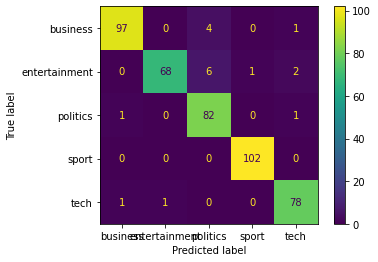

In [24]:
plot_confusion_matrix(clf, X_test, y_test) 
plt.show() 

In [25]:
clf.score(X_test,y_test)

0.9595505617977528